<a href="https://colab.research.google.com/github/nav-jk/raspberry-env-ml-nav/blob/main/Tiny_ML_Train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Baseline model

We will start by training a generic sound classifier model with TensorFlow using the [ESC-50: Dataset for Environmental Sound Classification](https://github.com/karolpiczak/ESC-50). This will allow us to create a more generic model that is trained on a broader dataset, and then use Transfer Learning later on to fine tune it for our specific audio classification task.

This model will be trained on the ESC-50 dataset, which contains 50 types of sounds; each sound category has 40 audio files that are 5 seconds each in length. Each audio file will be split into 1 second soundbites, and any soundbites that contain pure silence will be discarded.

### Prepare dataset

#### Download and extract

The ESC-50 dataset will be downloaded and extracted to the `datasets` folder using the [`tf.keras.utils.get_file(...)`](https://www.tensorflow.org/api_docs/python/tf/keras/utils/get_file) function.

In [ ]:
import tensorflow as tf

tf.keras.utils.get_file('esc-50.zip',
                        'https://github.com/karoldvl/ESC-50/archive/master.zip',
                        cache_dir='./',
                        cache_subdir='datasets',
                        extract=True)

645701632/Unknown 40s 0us/step

'./datasets/esc-50_extracted'

#### Load dataset metadata

Now we will use the [pandas](https://pandas.pydata.org/) library to read the `datasets/ESC-50-master/meta/esc50.csv` file which contains the metadata for the audio files in the ESC-50 dataset:

In [ ]:
import pandas as pd

esc50_csv = '/content/datasets/esc-50_extracted/ESC-50-master/meta/esc50.csv'
base_data_path = './content/datasets/esc-50_extracted/ESC-50-master/audio/'

df = pd.read_csv(esc50_csv)
df.head()

,filename,fold,target,category,esc10,src_file,take
0,1-100032-A-0.wav,1,0,dog,True,100032,A
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A


Then add new column with the `fullpath` of the wave files:

In [ ]:
from os import path

base_data_path = '/content/datasets/esc-50_extracted/ESC-50-master/audio/'

df['fullpath'] = df['filename'].map(lambda x: path.join(base_data_path, x))

df.head()

,filename,fold,target,category,esc10,src_file,take,fullpath
0,1-100032-A-0.wav,1,0,dog,True,100032,A,/content/datasets/esc-50_extracted/ESC-50-mast...
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A,/content/datasets/esc-50_extracted/ESC-50-mast...
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A,/content/datasets/esc-50_extracted/ESC-50-mast...
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B,/content/datasets/esc-50_extracted/ESC-50-mast...
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A,/content/datasets/esc-50_extracted/ESC-50-mast...


In [ ]:
!pip install resampy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 39.5 MB/s eta 0:00:00


In [ ]:
import os
from typing import Tuple, Union

import numpy as np
import tensorflow as tf
import wave
import contextlib

def _sanitize_audio(x: np.ndarray) -> np.ndarray:
    # Make finite and clamp to [-1, 1]
    x = np.nan_to_num(x, nan=0.0, posinf=0.0, neginf=0.0)
    x[np.abs(x) < 1e-20] = 0.0
    return np.clip(x, -1.0, 1.0).astype(np.float32, copy=False)

def _as_path_str(filename: Union[str, bytes, os.PathLike, tf.Tensor]) -> str:
    if isinstance(filename, tf.Tensor):
        filename = filename.numpy() if hasattr(filename, "numpy") else filename
    return filename.decode("utf-8") if isinstance(filename, (bytes, bytearray)) else str(filename)

def _read_wav_stdlib(path: str) -> Tuple[np.ndarray, int]:
    """PCM WAV decode via stdlib; returns float32 [-1,1], shape [N,C]."""
    with contextlib.closing(wave.open(path, "rb")) as wf:
        n_channels = wf.getnchannels()
        sampwidth  = wf.getsampwidth()
        framerate  = wf.getframerate()
        n_frames   = wf.getnframes()
        comptype   = wf.getcomptype()
        raw        = wf.readframes(n_frames)

    if comptype != "NONE":
        # Compressed WAV (e.g., ADPCM) not supported by stdlib
        raise ValueError(f"Compressed WAV not supported (comptype={comptype}).")

    if n_frames == 0 or len(raw) == 0:
        x = np.zeros((1, max(1, n_channels)), dtype=np.float32)
        return x, int(framerate)

    if sampwidth == 1:
        x = np.frombuffer(raw, dtype=np.uint8).astype(np.float32)
        x = (x - 128.0) / 128.0
    elif sampwidth == 2:
        x = np.frombuffer(raw, dtype=np.int16).astype(np.float32) / 32768.0
    elif sampwidth == 3:  # 24-bit sign-extend
        a = np.frombuffer(raw, dtype=np.uint8).reshape(-1, 3)
        b = (a[:,0].astype(np.uint32) |
             (a[:,1].astype(np.uint32) << 8) |
             (a[:,2].astype(np.uint32) << 16))
        sign = (b & 0x800000) != 0
        b = b | np.where(sign, 0xFF000000, 0).astype(np.uint32)
        x = b.view(np.int32).astype(np.float32) / 8388608.0
    elif sampwidth == 4:
        x = np.frombuffer(raw, dtype=np.int32).astype(np.float32) / 2147483648.0
    else:
        raise ValueError(f"Unsupported WAV sample width: {sampwidth} bytes")

    if n_channels > 1:
        n = (x.size // n_channels) * n_channels  # trim incomplete frame
        x = x[:n].reshape(-1, n_channels)
    else:
        x = x.reshape(-1, 1)

    return _sanitize_audio(x), int(framerate)

def _resample_1d_tfimage(audio_nc: np.ndarray, src_sr: int, dst_sr: int) -> np.ndarray:
    """Resample [N,C] along time using tf.image.resize (bilinear, antialias)."""
    if src_sr == dst_sr:
        return audio_nc
    n_in = int(audio_nc.shape[0])
    n_out = max(int(round(n_in * (dst_sr / float(src_sr)))), 1)
    x = tf.convert_to_tensor(audio_nc, dtype=tf.float32)      # [N, C]
    x = tf.expand_dims(tf.expand_dims(x, 0), 2)               # [1, N, 1, C]
    x = tf.image.resize(x, size=(n_out, 1), method="bilinear", antialias=True)
    x = tf.squeeze(x, axis=(0, 2))                            # [N_out, C]
    y = x.numpy()
    return _sanitize_audio(y)

def load_wav(
    filename: Union[str, bytes, os.PathLike, tf.Tensor],
    desired_sample_rate: int,
    desired_channels: int,
) -> Tuple[tf.Tensor, int]:
    """
    Load WAV -> float32 Tensor, resampled to desired_sample_rate and channels.
    No librosa, no tfio, no tf.signal.resample.
    """
    path = _as_path_str(filename)

    # 1) Try TF decode; fallback to stdlib PCM
    try:
        file_bytes = tf.io.read_file(path)
        wav, sr_tf = tf.audio.decode_wav(file_bytes)  # [N,C], float32
        audio_np = wav.numpy()
        sr = int(sr_tf.numpy())
    except Exception:
        audio_np, sr = _read_wav_stdlib(path)

    # 2) Sanitize and coerce to [N,C]
    audio_np = _sanitize_audio(np.asarray(audio_np, dtype=np.float32))
    if audio_np.ndim == 0:
        audio_np = np.array([[0.0]], dtype=np.float32)
    elif audio_np.ndim == 1:
        audio_np = audio_np[:, None]

    # 3) Match desired_channels
    in_ch = audio_np.shape[1]
    if desired_channels == 1:
        audio_np = np.mean(audio_np, axis=1, keepdims=True)
    elif in_ch == 1 and desired_channels > 1:
        audio_np = np.repeat(audio_np, repeats=desired_channels, axis=1)
    elif in_ch != desired_channels:
        if in_ch > desired_channels:
            audio_np = audio_np[:, :desired_channels]
        else:
            pad = np.repeat(audio_np[:, -1:], repeats=desired_channels - in_ch, axis=1)
            audio_np = np.concatenate([audio_np, pad], axis=1)

    audio_np = _sanitize_audio(audio_np)

    # 4) Resample (version-proof)
    target_sr = int(desired_sample_rate)
    if sr != target_sr:
        audio_np = _resample_1d_tfimage(audio_np, sr, target_sr)
        sr = target_sr

    # 5) Return canonical shapes
    if desired_channels == 1:
        audio_tf = tf.convert_to_tensor(np.squeeze(audio_np, axis=1), dtype=tf.float32)  # [N]
    else:
        audio_tf = tf.convert_to_tensor(audio_np, dtype=tf.float32)                      # [N, C]

    return audio_tf, sr


Now let's load the first wave file, which is a sound of a dog barking, from the pandas `DataFrame`, and plot it overtime using `matplotlib`. The [`IPython.display.Audio(...)`](https://ipython.org/ipython-doc/3/api/generated/IPython.display.html#IPython.display.Audio) API can be used to playback the audio samples inside the notebook.




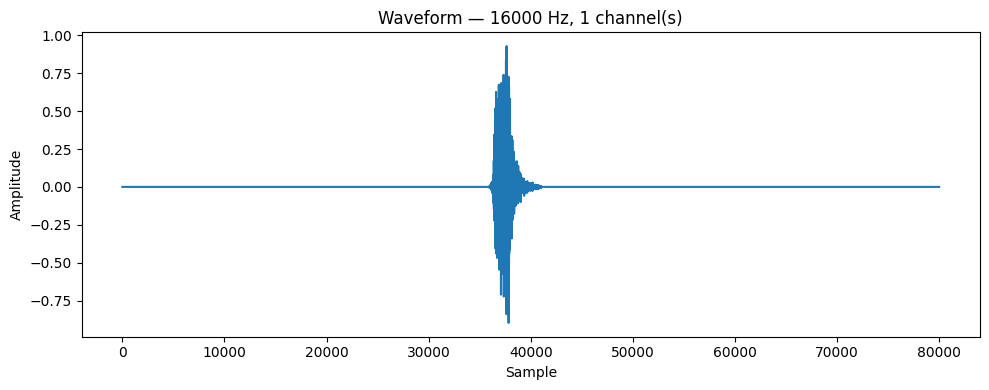

In [ ]:
import matplotlib.pyplot as plt
from IPython.display import Audio, display
import numpy as np

sample_rate = 16000
channels = 1

# Load audio (returns tensor and sample rate)
audio_tensor, sr = load_wav(df['fullpath'][0], sample_rate, channels)

# Convert to NumPy for plotting
audio_np = audio_tensor.numpy() if hasattr(audio_tensor, "numpy") else np.asarray(audio_tensor)

# Plot waveform
plt.figure(figsize=(10, 4))
if audio_np.ndim == 1:
    plt.plot(audio_np)
else:
    for c in range(audio_np.shape[1]):
        plt.plot(audio_np[:, c], label=f"Channel {c+1}")
    plt.legend()

plt.title(f"Waveform — {sr} Hz, {channels} channel(s)")
plt.xlabel("Sample")
plt.ylabel("Amplitude")
plt.tight_layout()
plt.show()

# Play audio in notebook
display(Audio(audio_np.T, rate=sr))


In [ ]:
audio_np

array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

In [ ]:
test_wav_file_path = df['fullpath'][0]

If we zoom in and only plot samples `32000` to `48000`, we can get a closer plot of the audio samples in the wave file in the 2 to 3 second span:

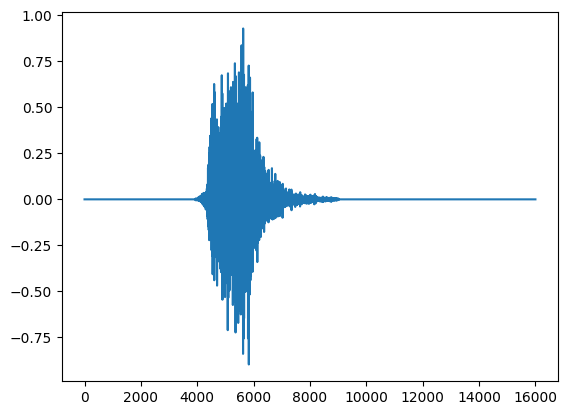

In [ ]:
_ = plt.plot(audio_np[32000:48000])

We can then use the [`tf.data.Dataset`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) TensorFlow API to create a pipeline that loads all wave file data from the dataset.

In [ ]:
fullpaths = df['fullpath']
targets = df['target']
folds = df['fold']

fullpaths_ds = tf.data.Dataset.from_tensor_slices((fullpaths, targets, folds))
fullpaths_ds.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

Map each `fullpath` value to wave file samples:

In [ ]:
def load_wav_for_map(fullpath, label, fold):
  # load_wav returns (audio_tensor, sr)
  wav, _ = tf.py_function(load_wav, [fullpath, sample_rate, 1], (tf.float32, tf.int32))
  wav.set_shape(sample_rate * 5) # Set shape for 5 seconds of audio
  return wav, label, fold

wav_ds = fullpaths_ds.map(load_wav_for_map)
wav_ds.element_spec

(TensorSpec(shape=(80000,), dtype=tf.float32, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

#### Split Wave file data

We would like to train the model on 1 secound soundbites, so we must split up the 5 seconds of audio per item in the ESC-50 dataset to slices of 16000 samples. We will also stride the original audio samples `4000` samples at a time, and filter out any sound chunks that contain pure silence.

In [ ]:
@tf.function
def split_wav(wav, width, stride):
  return tf.map_fn(fn=lambda t: wav[t * stride:t * stride + width], elems=tf.range((tf.shape(wav)[0] - width) // stride), fn_output_signature=tf.float32)

@tf.function
def wav_not_empty(wav):
  return tf.experimental.numpy.any(wav)

def split_wav_for_flat_map(wav, label, fold):
  wavs = split_wav(wav, width=16000, stride=4000)
  wavs.set_shape([None, 16000]) # Set shape for a batch of 1-second soundbites
  labels = tf.repeat(label, tf.shape(wavs)[0])
  folds = tf.repeat(fold, tf.shape(wavs)[0])

  return tf.data.Dataset.from_tensor_slices((wavs, labels, folds))

split_wav_ds = wav_ds.flat_map(split_wav_for_flat_map)
split_wav_ds = split_wav_ds.filter(lambda x, y, z: wav_not_empty(x))

Let's plot the first 5 soundbites over time using `matplotlib`:

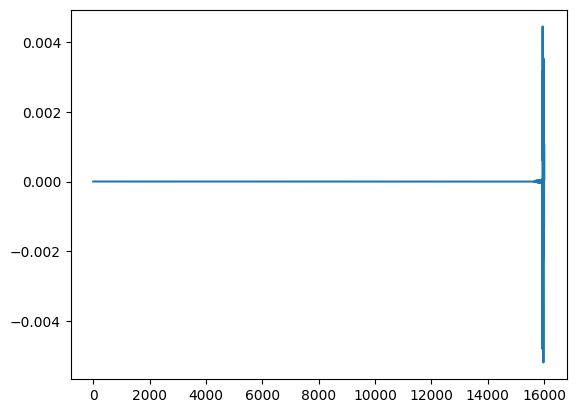

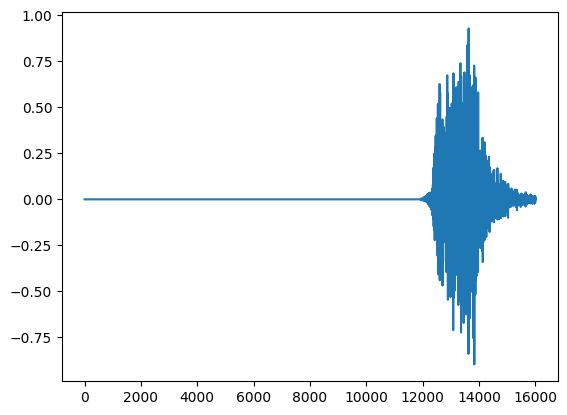

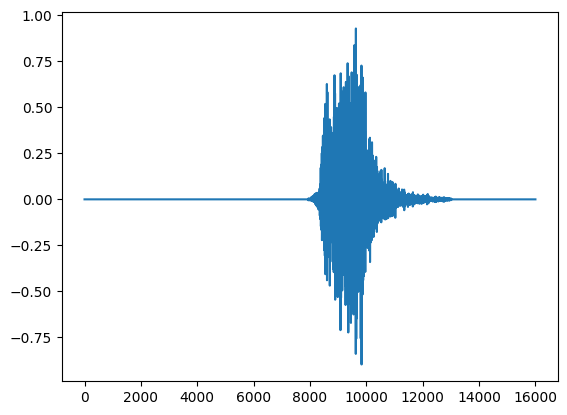

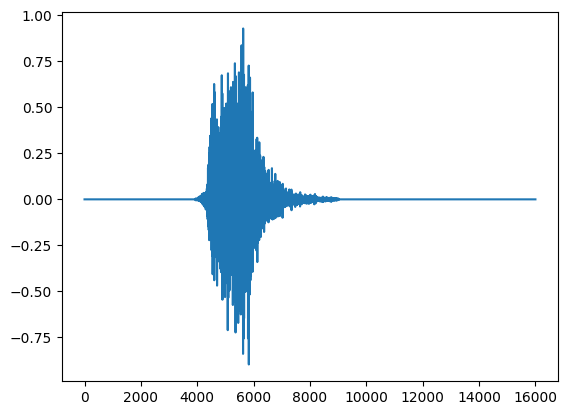

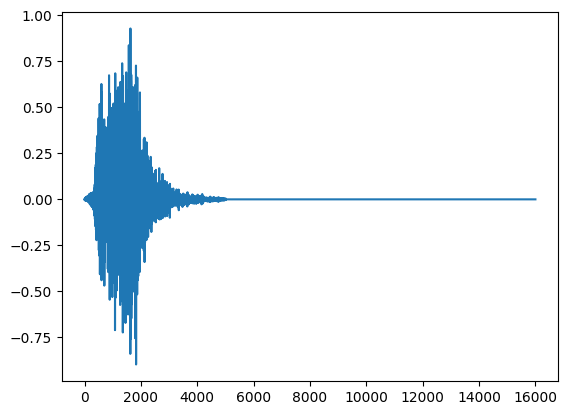

In [ ]:
for wav, _, _ in split_wav_ds.take(5):
  _ = plt.plot(wav)
  plt.show()

#### Create Spectrograms

Rather than passing in the time series data directly into our TensorFlow model, we will transform the audio data into an audio spectrogram representation. This will create a 2D representation of the audio signal’s frequency content over time.

The input audio signal we will use will have a sampling rate of 16kHz, this means one second of audio will contain 16,000 samples. Using TensorFlow’s [`tf.signal.stft(...)`](https://www.tensorflow.org/api_docs/python/tf/signal/stft) function we can transform a 1 second audio signal into a 2D tensor representation. We will choose a frame length of 256 and a frame step of 128, so the output of this feature extraction stage will be a Tensor that has a shape of `(124, 129)`.


In [ ]:
@tf.function
def create_spectrogram(samples, target_size=None):
  spectrogram = tf.abs(
      tf.signal.stft(samples, frame_length=256, frame_step=128)
  )
  if target_size:
      spectrogram = tf.image.resize(
          tf.expand_dims(spectrogram, axis=-1),
          target_size,
          method=tf.image.ResizeMethod.BILINEAR,
          antialias=True
      )
      spectrogram = tf.squeeze(spectrogram, axis=-1)
  return spectrogram

Let's take the same 2 - 3 second interval of the first dog barking wave file and create it's spectrogram representation:

In [ ]:
spectrogram = create_spectrogram(audio_np[32000:48000], target_size=[32, 32])

spectrogram.shape

In [ ]:
!pip install tensorflow-model-optimization
import tensorflow_model_optimization as tfmot

# Load the model
# Ensure final_model is loaded if not already in memory from previous execution
# (though the previous cell loads it, it's good practice for standalone execution)
try:
    _ = final_model
except NameError:
    final_model = tf.keras.models.load_model("fine_tuned_model.keras")

# Apply quantization-aware training annotations to the entire model
annotated_model = tfmot.quantization.keras.quantize_annotate_model(final_model)

# Create the quant-aware model from the annotated model
quant_aware_model = tfmot.quantization.keras.quantize_apply(annotated_model)
quant_aware_model.summary()

# Now, convert the quant_aware_model
converter = tf.lite.TFLiteConverter.from_keras_model(quant_aware_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

def representative_data_gen():
  # Assuming train_ds is available and contains resized spectrograms
  for input_value, output_value in train_ds.unbatch().batch(1).take(100):
    # Model has only one input so each data point has one element.
    yield [input_value]

converter.representative_dataset = representative_data_gen
# Ensure that if any ops can't be quantized, the converter throws an error
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# Set the input and output tensors to int8 (APIs added in r2.3)
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8
tflite_model_quant = converter.convert()

# Save the model.
with open('tflite_model.tflite', 'wb') as f:
  f.write(tflite_model_quant)

In [ ]:
!pip install tensorflow-model-optimization
import tensorflow_model_optimization as tfmot

# Load the model
# Ensure final_model is loaded if not already in memory from previous execution
# (though the previous cell loads it, it's good practice for standalone execution)
try:
    _ = final_model
except NameError:
    final_model = tf.keras.models.load_model("fine_tuned_model.keras")

# Apply quantization-aware training annotations to the entire model
annotated_model = tfmot.quantization.keras.quantize_annotate_model(final_model)

# Create the quant-aware model from the annotated model
quant_aware_model = tfmot.quantization.keras.quantize_apply(annotated_model)
quant_aware_model.summary()

# Now, convert the quant_aware_model
converter = tf.lite.TFLiteConverter.from_keras_model(quant_aware_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

def representative_data_gen():
  # Assuming train_ds is available and contains resized spectrograms
  for input_value, output_value in train_ds.unbatch().batch(1).take(100):
    # Model has only one input so each data point has one element.
    yield [input_value]

converter.representative_dataset = representative_data_gen
# Ensure that if any ops can't be quantized, the converter throws an error
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# Set the input and output tensors to int8 (APIs added in r2.3)
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8
tflite_model_quant = converter.convert()

# Save the model.
with open('tflite_model.tflite', 'wb') as f:
  f.write(tflite_model_quant)

In [ ]:
!pip install tensorflow-model-optimization
import tensorflow_model_optimization as tfmot

# Load the model
# Ensure final_model is loaded if not already in memory from previous execution
# (though the previous cell loads it, it's good practice for standalone execution)
try:
    _ = final_model
except NameError:
    final_model = tf.keras.models.load_model("fine_tuned_model.keras")

# Apply quantization-aware training annotations to the entire model
annotated_model = tfmot.quantization.keras.quantize_annotate_model(final_model)

# Create the quant-aware model from the annotated model
quant_aware_model = tfmot.quantization.keras.quantize_apply(annotated_model)
quant_aware_model.summary()

# Now, convert the quant_aware_model
converter = tf.lite.TFLiteConverter.from_keras_model(quant_aware_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

def representative_data_gen():
  # Assuming train_ds is available and contains resized spectrograms
  for input_value, output_value in train_ds.unbatch().batch(1).take(100):
    # Model has only one input so each data point has one element.
    yield [input_value]

converter.representative_dataset = representative_data_gen
# Ensure that if any ops can't be quantized, the converter throws an error
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# Set the input and output tensors to int8 (APIs added in r2.3)
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8
tflite_model_quant = converter.convert()

# Save the model.
with open('tflite_model.tflite', 'wb') as f:
  f.write(tflite_model_quant)

We can then create `plot_spectrogram` function to plot the spectrogram representation using `matplotlib`:

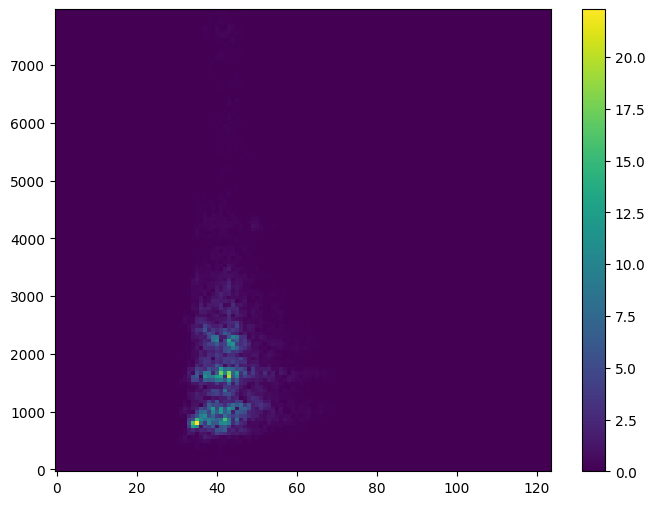

In [ ]:
import numpy as np

def plot_spectrogram(spectrogram, vmax=None):
  transposed_spectrogram = tf.transpose(spectrogram)

  fig = plt.figure(figsize=(8,6))
  height = transposed_spectrogram.shape[0]
  X = np.arange(transposed_spectrogram.shape[1])
  Y = np.arange(height * int(sample_rate / 256), step=int(sample_rate / 256))

  im = plt.pcolormesh(X, Y, tf.transpose(spectrogram), vmax=vmax)

  fig.colorbar(im)
  plt.show()


plot_spectrogram(spectrogram)

Then we can map each split wave item to a spectrogram:

In [ ]:
def create_spectrogram_for_map(samples, label, fold):
  # Resize to 32x32 here, as the resizing layer is removed from the model
  spectrogram = create_spectrogram(samples, target_size=[32, 32])
  spectrogram.set_shape([32, 32]) # Set shape for the spectrogram output
  return spectrogram, label, fold

spectrograms_ds = split_wav_ds.map(create_spectrogram_for_map)
spectrograms_ds.element_spec

NameError: name 'split_wav_ds' is not defined

Let's plot the first 5 spectrograms in the dataset:

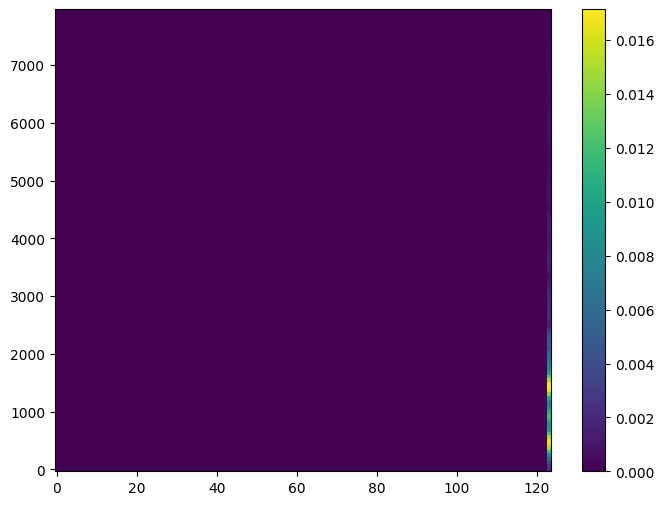

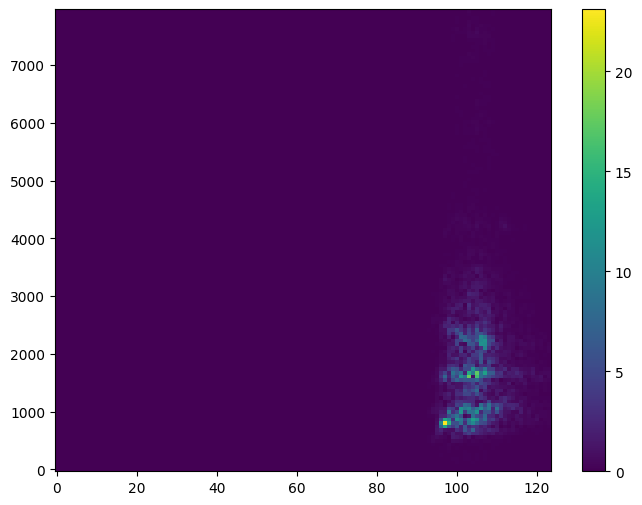

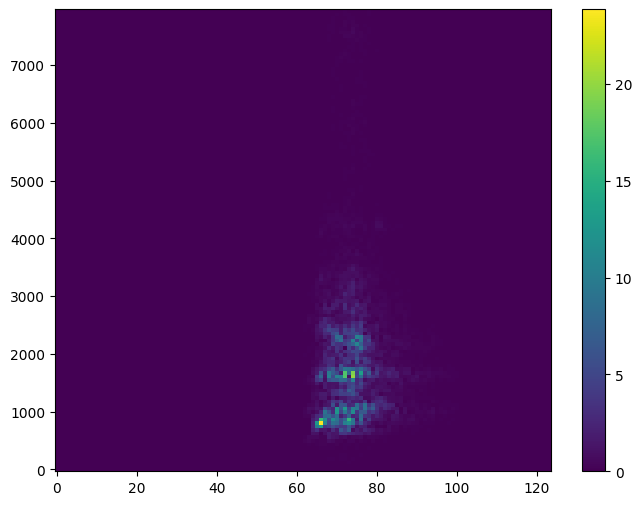

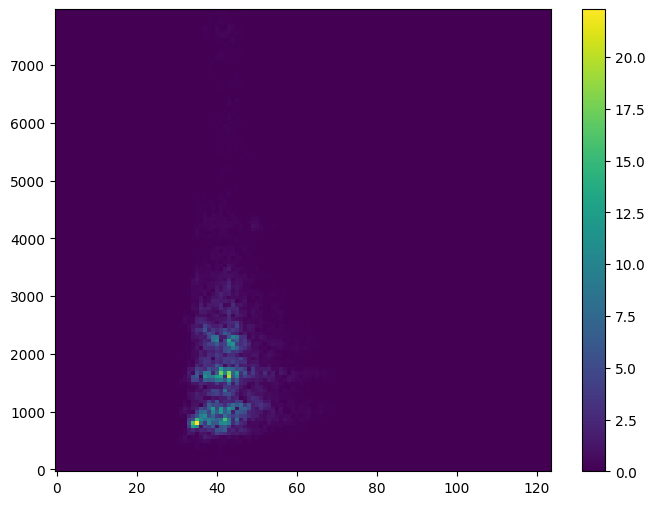

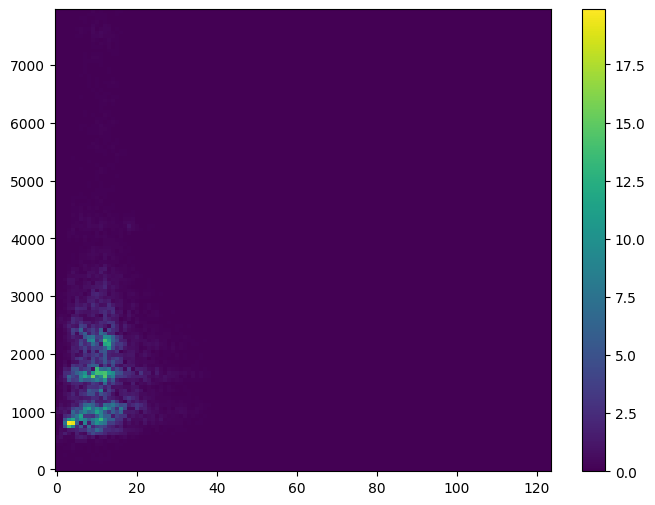

In [ ]:
for s, _, _ in spectrograms_ds.take(5):
  plot_spectrogram(s)

### Split Dataset

Before we start training the ML classifier model, we must split the dataset up in three parts: training, validation, and test.

We will use the same technique in TensorFlow's [Transfer learning with YAMNet for environmental sound classification](https://www.tensorflow.org/tutorials/audio/transfer_learning_audio#split_the_data) guide, and use the `fold` column of the ESC-50 dataset to determine the split.

Before splitting the dataset, let's set a random seed for reproducibility:

In [ ]:
import numpy as np
import tensorflow as tf

# Set seed for experiment reproducibility
random_seed = 42
tf.random.set_seed(random_seed)
np.random.seed(random_seed)

Entries with a `fold` value of less than 4 will used for training, the ones with a `value` will be used for validation, and finally the remaining items with be used for testing.

The `fold` column will be removed as it is no longer needed, and the dimensions of the spectrogram shape will be expanded from `(124, 129)` to `(124, 129, 1)`. The training items will also be shuffled.

In [ ]:
cached_ds = spectrograms_ds.cache()

train_ds = cached_ds.filter(lambda spectrogram, label, fold: fold < 4)
val_ds = cached_ds.filter(lambda spectrogram, label, fold: fold == 4)
test_ds = cached_ds.filter(lambda spectrogram, label, fold: fold > 4)

# remove the folds column as it's no longer needed
# Explicitly cast to tf.float32 for spectrogram and tf.int32 for label
remove_fold_column = lambda spectrogram, label, fold: (tf.cast(tf.expand_dims(spectrogram, axis=-1), tf.float32), tf.cast(label, tf.int32))

train_ds = train_ds.map(remove_fold_column)
val_ds = val_ds.map(remove_fold_column)
test_ds = test_ds.map(remove_fold_column)

print("--- Diagnostic Info for train_ds and val_ds before batching ---")
print("train_ds.element_spec:", train_ds.element_spec)
print("val_ds.element_spec:", val_ds.element_spec)

try:
    _ = next(iter(train_ds))
    print("train_ds is NOT empty!")
except tf.errors.OutOfRangeError:
    print("train_ds IS EMPTY!")

try:
    _ = next(iter(val_ds))
    print("val_ds is NOT empty!\n")
except tf.errors.OutOfRangeError:
    print("val_ds IS EMPTY!")
print("----------------------------------------------------------------")

train_ds = train_ds.cache().shuffle(1000, seed=random_seed).batch(32).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.cache().batch(32).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.cache().batch(32).prefetch(tf.data.AUTOTUNE)

--- Diagnostic Info for train_ds and val_ds before batching ---
train_ds.element_spec: (TensorSpec(shape=(124, 129, 1), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None))
val_ds.element_spec: (TensorSpec(shape=(124, 129, 1), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None))
train_ds is NOT empty!
val_ds is NOT empty!

----------------------------------------------------------------


### Train Model

Now that we have the features extracted from the audio signal, we can create a model using TensorFlow’s Keras  API. The model will consist of 8 layers:

 1. An input layer.
 1. A preprocessing layer, that will resize the input tensor from 124x129x1 to 32x32x1.
 1. A normalization layer, that will scale the input values between -1 and 1
 1. A 2D convolution layer with: 8 filters, a kernel size of 8x8, and stride of 2x2, and ReLU activation function.
 1. A 2D max pooling layer with size of 2x2
 1. A flatten layer to flatten the 2D data to 1D
 1. A dropout layer, that will help reduce overfitting during training
 1. A dense layer with 50 outputs and a softmax activation function, which outputs the likelihood of the sound category (between 0 and 1).


Before we build the model using [Tensflow's Keras API's](https://www.tensorflow.org/api_docs/python/tf/keras), we will create normalization layer and feed in all the spectrogram dataset items.

In [ ]:
for spectrogram, _, _ in cached_ds.take(1):
    # original_input_shape should now reflect the already resized spectrograms
    original_input_shape = tf.expand_dims(spectrogram, axis=-1).shape
    print('Input shape for model (after preprocessing):', original_input_shape)

# Create a temporary Resizing layer to apply to the dataset for adaptation
# This layer is no longer in the model itself, but we need to ensure the data is resized
# before adaptation, if cached_ds contains non-resized data. If create_spectrogram_for_map
# now resizes, then cached_ds elements are already resized.

# Adapt the normalization layer directly on the already resized spectrograms
# `cached_ds` elements now have the target shape (32, 32)
adapt_ds = cached_ds.map(lambda x, y, z: tf.expand_dims(x, axis=-1)).batch(32).take(10)

norm_layer = tf.keras.layers.Normalization()
# Adapt the normalization layer on this prepared dataset
norm_layer.adapt(adapt_ds)

# The `input_shape` for the model's Input layer now matches the resized spectrograms.
input_shape = original_input_shape

NameError: name 'cached_ds' is not defined

Define a sequential 8 layer model as described above:

In [ ]:
norm_layer = tf.keras.layers.Normalization(axis=-1, dtype=tf.float32)
# IMPORTANT: adapt on (H, W, C) tensors, e.g. spectrograms after your preprocessing/resizing step
# norm_layer.adapt(ds.map(lambda x, y: x))  # where x is [B, H, W, C]

input_shape = (124, 129, 1)

baseline_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=input_shape),
    tf.keras.layers.Resizing(32, 32, interpolation="bilinear", antialias=True),  # better for spectrograms
    norm_layer,
    tf.keras.layers.Conv2D(8, kernel_size=(8, 8), strides=(2, 2), padding="same", activation="relu"),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2)),
    # Global pooling is more robust than Flatten and reduces params
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(50, activation="softmax"),
])

baseline_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization (Normalization)   │ (None, 32, 32, 1)      │             3 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 16, 16, 8)      │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 8, 8, 8)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 8)              │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 50)             │           450 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 973 (3.80 KB)

 Trainable params: 970 (3.79 KB)

 Non-trainable params: 3 (16.00 B)

Compile the model with `accuracy` metrics, an Adam optimizer and a sparse categorical crossentropy loss function. As well as define early stopping and dynamic learning rate scheduler callbacks for training.

In [ ]:
METRICS = [
      "accuracy",
]

baseline_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=METRICS,
)

def scheduler(epoch, lr):
  if epoch < 100:
    return lr
  else:
    return lr * tf.math.exp(-0.1)

callbacks = [
    tf.keras.callbacks.EarlyStopping(verbose=1, patience=25),
    tf.keras.callbacks.LearningRateScheduler(scheduler)
]

Train the model:

In [ ]:
EPOCHS = 250
history = baseline_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=callbacks,
)

Epoch 1/250
    555/Unknown 113s 195ms/step - accuracy: 0.0315 - loss: 3.8599

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


557/557 ━━━━━━━━━━━━━━━━━━━━ 116s 201ms/step - accuracy: 0.0315 - loss: 3.8597 - val_accuracy: 0.0295 - val_loss: 3.8292 - learning_rate: 0.0010
Epoch 2/250
557/557 ━━━━━━━━━━━━━━━━━━━━ 13s 24ms/step - accuracy: 0.0668 - loss: 3.6945 - val_accuracy: 0.0818 - val_loss: 3.6703 - learning_rate: 0.0010
Epoch 3/250
557/557 ━━━━━━━━━━━━━━━━━━━━ 30s 53ms/step - accuracy: 0.0820 - loss: 3.5861 - val_accuracy: 0.0831 - val_loss: 3.5710 - learning_rate: 0.0010
Epoch 4/250
557/557 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step - accuracy: 0.0911 - loss: 3.5167 - val_accuracy: 0.0974 - val_loss: 3.5095 - learning_rate: 0.0010
Epoch 5/250
557/557 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step - accuracy: 0.0936 - loss: 3.4593 - val_accuracy: 0.1061 - val_loss: 3.4614 - learning_rate: 0.0010
Epoch 6/250
557/557 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step - accuracy: 0.1048 - loss: 3.4180 - val_accuracy: 0.1066 - val_loss: 3.4258 - learning_rate: 0.0010
Epoch 7/250
557/557 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step - accuracy: 0.1060 - loss

KeyboardInterrupt: 

Evaluate the loss and accuracy of the test dataset:

In [ ]:
baseline_model.evaluate(test_ds)

187/187 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.2242 - loss: 3.0440


[3.065256357192993, 0.22399061918258667]

The baseline model has a relatively low accuracy ~24%, however in the next steps we will use it as a starting point to fine tune a more accurate model for our use case.

Save the model:

In [ ]:
baseline_model.save("baseline_model.keras")

Create a zip file of the saved model, for download purposes:

In [ ]:
!zip -r baseline_model.zip baseline_model.keras

  adding: baseline_model.keras (deflated 68%)


## Transfer Learning

Now we will use Transfer Learning and change the classification head of the model to train a binary classification model for fire alarm sounds.

Transfer Learning is the process of retraining a model that has been developed for a task to complete a new similar task. The idea is that the model has learned transferable "skills" and the weights and biases can be used in other models as a starting point.

Transfer learning is very common in computer vision. Big data companies spend weeks training models on ImageNet, this is not possible for most people and so people reuse the models built in these research companies to complete their own tasks. A model designed to recognise 1000 different objects in a image can be adapted to recognise other or similar objects.

As humans we use transfer learning too. The skills you developed to learn to walk could also be used to learn to run later on.

In a neural network, the first few layers of a model start to perform a "feature extraction" such as finding shapes, edges and colours. The layers later on are used as classifiers; they take the extracted features and classify them.

You can find more information and visualizations about this here https://yosinski.com/deepvis.

Because of this, we can assume the first few layers have learned quite general feature extraction techniques that can be applied to all similar tasks and so we can freeze all these layers. The classifier layer will need to be trained based on the new classes.

To do this, we break the process into two steps:
Freeze the "backbone" of the model and train the head with a fairly high learning rate. We slowly reduce the learning rate.
Unfreeze the "backbone" and fine-tune the model with a low learning rate.


### Dataset

We have collected 10 fire alarm clips from [freesound.org](https://freesound.org/) and [BigSoundBank.com](https://bigsoundbank.com/).  Background noise clips from the [SpeechCommands](https://www.tensorflow.org/datasets/catalog/speech_commands) dataset, will be used for non-fire alarm sounds. This dataset is small and represents the sort of data you might expect to see in the real world. Data augmentation techniques will be used to supplement the training data we’ve collected.

### Download datasets

We've created an archive with the following wave files for you:

 * https://freesound.org/people/rayprice/sounds/155006/ ([CC BY 3.0 license](https://creativecommons.org/licenses/by/3.0/))

 * https://freesound.org/people/deleted_user_2104797/sounds/164686/ ([CC0 1.0 license](https://creativecommons.org/publicdomain/zero/1.0/))

 * https://freesound.org/people/AdamWeeden/sounds/255180/ ([CC BY 3.0 license](https://creativecommons.org/licenses/by/3.0/))

* https://freesound.org/people/MoonlightShadow/sounds/325367/([CC0 1.0 license](https://creativecommons.org/publicdomain/zero/1.0/))

* https://freesound.org/people/SpliceSound/sounds/369847/ ([CC0 1.0 license](https://creativecommons.org/publicdomain/zero/1.0/))

* https://freesound.org/people/SpliceSound/sounds/369848/ ([CC0 1.0 license](https://creativecommons.org/publicdomain/zero/1.0/))

* https://bigsoundbank.com/detail-0800-smoke-detector-alarm.html ([free of charge and royalty free.](https://bigsoundbank.com/droit.html))

* https://bigsoundbank.com/detail-1151-smoke-detector-alarm-2.html ([free of charge and royalty free.](https://bigsoundbank.com/droit.html))

* https://bigsoundbank.com/detail-1153-smoke-detector-alarm-3.html ([free of charge and royalty free.](https://bigsoundbank.com/droit.html))


In [ ]:
tf.keras.utils.get_file('fire_alarms.tar.gz',
                        'https://github.com/ArmDeveloperEcosystem/ml-audio-classifier-example-for-pico/archive/refs/heads/fire_alarms.tar.gz',
                        cache_dir='./',
                        cache_subdir='datasets',
                        extract=True)

44310528/Unknown 3s 0us/step

'./datasets/fire_alarms_extracted'

In [ ]:
# Since we only need the files in the _background_noise_ folder of the dataset
# use the curl command to download the archive file and then manually extract
# using the tar command, instead of using tf.keras.utils.get_file(...)
# in Python

!mkdir -p datasets/speech_commands
!curl -L -o datasets/speech_commands_v0.02.tar.gz http://download.tensorflow.org/data/speech_commands_v0.02.tar.gz
!tar --wildcards --directory datasets/speech_commands -xzvf datasets/speech_commands_v0.02.tar.gz './_background_noise_/*'

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2316M  100 2316M    0     0  63.5M      0  0:00:36  0:00:36 --:--:-- 42.5M
./_background_noise_/README.md
./_background_noise_/pink_noise.wav
./_background_noise_/running_tap.wav
./_background_noise_/exercise_bike.wav
./_background_noise_/doing_the_dishes.wav
./_background_noise_/dude_miaowing.wav
./_background_noise_/white_noise.wav


### Load dataset

Instead of using a pandas DataFrame to load the dataset, we will load the fire alarm files and background noise files separately. The `label` and `fold` values will be mapped manually.

In [ ]:
!pip install soundfile

In [ ]:
import soundfile as sf

DESIRED_SAMPLES = 80000  # change to your target length

def _read_wav_with_soundfile(path_str):
    # path_str is a python bytes (from tf.py_function)
    path = path_str.decode('utf-8')
    # read as float32 (soundfile returns float32 in range [-1.0, 1.0])
    data, sr = sf.read(path, dtype='float32')
    # If multi-channel, take first channel (or mix)
    if data.ndim > 1:
        data = np.mean(data, axis=1).astype(np.float32)
    return data, np.int32(sr)

def load_wav_for_map_py(filename, label, _dummy):
    # tf.py_function wrapper that returns (wav, sr, label) as tensors
    wav, sr = tf.py_function(func=_pyfunc_readwrap,
                             inp=[filename],
                             Tout=[tf.float32, tf.int32])
    # tf.py_function produces tensors with unknown shape; set it
    wav.set_shape([None])
    sr.set_shape([])

    # pad/truncate to DESIRED_SAMPLES
    wav = wav[:DESIRED_SAMPLES]
    cur_len = tf.shape(wav)[0]
    pad_len = tf.maximum(DESIRED_SAMPLES - cur_len, 0)
    wav = tf.pad(wav, [[0, pad_len]])
    wav = wav[:DESIRED_SAMPLES]

    return wav, sr, label

def _pyfunc_readwrap(filename):
    # helper used by tf.py_function (runs in Python, not in graph)
    # filename: tf string tensor -> will be bytes on Python side
    wav_np, sr = _read_wav_with_soundfile(filename.numpy())
    return wav_np, sr

# If you prefer a pure tf.py_function approach without `.numpy()` inside the helper,
# use this variant wrapper:
def _pyfunc_readwrap(filename):
    path = filename.numpy().decode('utf-8')
    data, sr = sf.read(path, dtype='float32')
    if data.ndim > 1:
        data = np.mean(data, axis=1).astype(np.float32)
    return data.astype(np.float32), np.int32(sr)

In [ ]:
fire_alarm_files_ds = tf.data.Dataset.list_files(
    "/content/datasets/fire_alarms_extracted/ml-audio-classifier-example-for-pico-fire_alarms/*.wav",
    shuffle=False
)
fire_alarm_files_ds = fire_alarm_files_ds.map(lambda x: (x, 1, -1))

background_noise_files_ds = tf.data.Dataset.list_files(
    "datasets/speech_commands/_background_noise_/*.wav",
    shuffle=False
)
background_noise_files_ds = background_noise_files_ds.map(lambda x: (x, 0, -1))

# Map the loader
fire_alarm_wav_ds = fire_alarm_files_ds.map(load_wav_for_map_py, num_parallel_calls=tf.data.AUTOTUNE).cache()
background_noise_wav_ds = background_noise_files_ds.map(load_wav_for_map_py, num_parallel_calls=tf.data.AUTOTUNE).cache()

Let's plot and listen to the first fire alarm file:

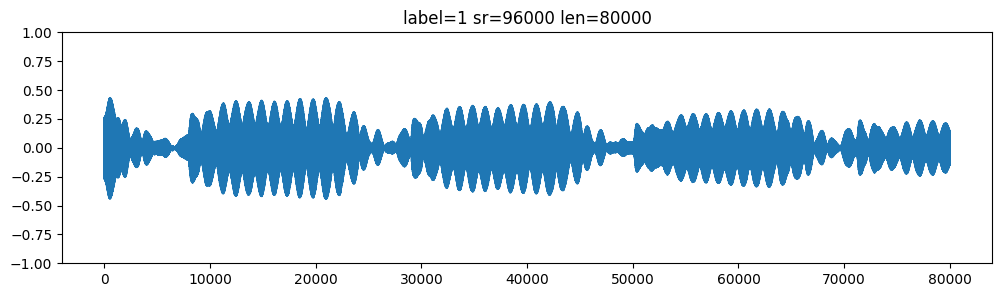

NameError: name 'ipydisplay' is not defined

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
for wav_data, sample_rate, label in fire_alarm_wav_ds.take(1):
    wav_np = wav_data.numpy()
    sr = int(sample_rate.numpy())
    plt.figure(figsize=(12,3))
    plt.plot(wav_np)
    plt.ylim([-1, 1])
    plt.title(f'label={int(label.numpy())} sr={sr} len={wav_np.shape[0]}')
    plt.show()
    ipydisplay.display(ipydisplay.Audio(wav_np, rate=sr))


Then do the same for the first background noise file:

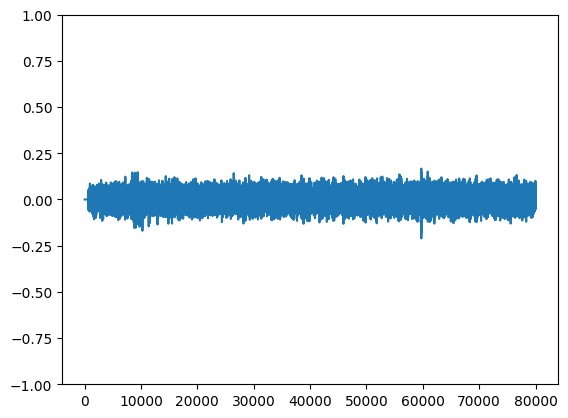

In [ ]:
from IPython import display

for wav_data, sample_rate, label in background_noise_wav_ds.take(1):
    wav_np = wav_data.numpy()

    plt.plot(wav_np)
    plt.ylim([-1, 1])
    plt.show()

    display.display(display.Audio(wav_np, rate=int(sample_rate.numpy())))


Then split the audio samples into 1 second soundbites:

In [ ]:
split_fire_alarm_wav_ds = fire_alarm_wav_ds.flat_map(split_wav_for_flat_map)
split_fire_alarm_wav_ds = split_fire_alarm_wav_ds.filter(lambda x, y, z: wav_not_empty(x))

split_background_noise_wav_ds = background_noise_wav_ds.flat_map(split_wav_for_flat_map)
split_background_noise_wav_ds = split_background_noise_wav_ds.filter(lambda x, y, z: wav_not_empty(x))

In [ ]:
import cmsisdsp
from numpy import pi as PI

window_size = 256
step_size = 128

hanning_window_f32 = np.zeros(window_size)
for i in range(window_size):
  hanning_window_f32[i] = 0.5 * (1 - cmsisdsp.arm_cos_f32(2 * PI * i / window_size ))

hanning_window_q15 = cmsisdsp.arm_float_to_q15(hanning_window_f32)

rfftq15 = cmsisdsp.arm_rfft_instance_q15()
status = cmsisdsp.arm_rfft_init_q15(rfftq15, window_size, 0, 1)

def get_arm_spectrogram(waveform):

  num_frames = int(1 + (len(waveform) - window_size) // step_size)
  fft_size = int(window_size // 2 + 1)

  # Convert the audio to q15
  waveform_q15 = cmsisdsp.arm_float_to_q15(waveform)

  # Create empty spectrogram array
  spectrogram_q15 = np.empty((num_frames, fft_size), dtype = np.int16)

  start_index = 0

  for index in range(num_frames):
    # Take the window from the waveform.
    window = waveform_q15[start_index:start_index + window_size]

    # Apply the Hanning Window.
    window = cmsisdsp.arm_mult_q15(window, hanning_window_q15)

    # Calculate the FFT, shift by 7 according to docs
    window = cmsisdsp.arm_rfft_q15(rfftq15, window)

    # Take the absolute value of the FFT and add to the Spectrogram.
    spectrogram_q15[index] = cmsisdsp.arm_cmplx_mag_q15(window)[:fft_size]

    # Increase the start index of the window by the overlap amount.
    start_index += step_size

  # Convert to numpy output ready for keras
  return cmsisdsp.arm_q15_to_float(spectrogram_q15).reshape(num_frames,fft_size) * 512

Let's create a spectrogram representation for all of the fire alarm soundbites, and plot the first spectrogram.

In [ ]:
def get_arm_spectrogram(samples):
    spectogram = create_spectrogram(wav)
    return spectogram

In [ ]:
@tf.function
def create_arm_spectrogram_for_map(wav, label, fold):
  # Resize to 32x32 here, as the resizing layer is removed from the model
  spectrogram = create_spectrogram(wav, target_size=[32, 32])
  spectrogram.set_shape([32, 32]) # Set shape for the spectrogram output
  return spectrogram, label, fold

fire_alarm_spectrograms_ds = split_fire_alarm_wav_ds.map(create_arm_spectrogram_for_map)
fire_alarm_spectrograms_ds = fire_alarm_spectrograms_ds.cache()

for spectrogram, _, _ in fire_alarm_spectrograms_ds.take(1):
  plot_spectrogram(spectrogram)

The do the same for the background noise soundbites:

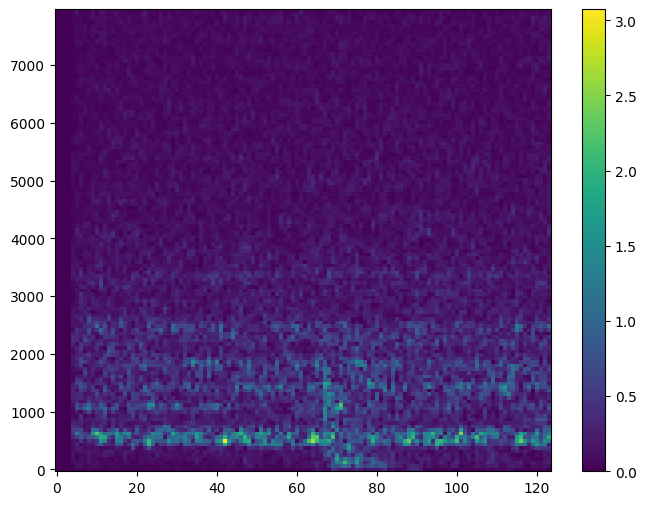

In [ ]:
background_noise_spectrograms_ds = split_background_noise_wav_ds.map(create_arm_spectrogram_for_map)
background_noise_spectrograms_ds = background_noise_spectrograms_ds.cache()

for spectrogram, _, _ in background_noise_spectrograms_ds.take(1):
  plot_spectrogram(spectrogram)

Now let's calculate the lengths of each dataset to see how balanced they are:

In [ ]:
def calculate_ds_len(ds):
  count = 0
  for _, _, _ in ds:
    count += 1

  return count

num_fire_alarm_spectrograms = calculate_ds_len(fire_alarm_spectrograms_ds)
num_background_noise_spectrograms = calculate_ds_len(background_noise_spectrograms_ds)

print(f"num_fire_alarm_spectrograms = {num_fire_alarm_spectrograms}")
print(f"num_background_noise_spectrograms = {num_background_noise_spectrograms}")

num_fire_alarm_spectrograms = 144
num_background_noise_spectrograms = 96


We can see there a more background noise samples than fire alarm samples. In the next section we will use data augmentation to balance this.

### Data Augmentation

Data augmentation is a set of techniques used to increase the size of a dataset. This is done by slightly modifying samples from the dataset or by creating synthetic data. In this situation we are using audio and we will create a few functions to augment the different samples. We will use three techniques:

 * adding white noise to the audio samples
 * adding random silence to the audio
 * mixing two audio samples together

As well as increasing the size of the dataset, data augmentation also helps to reduce overfitting by training the model on different (not perfect) data samples. For example, on a microcontroller you are unlikely to have perfect high quality audio, and so a technique like adding white noise can help the model work in situations where your microphone might every so often have noise in there.

First let's plot the time representation of the first fire alarm soundbite over time along with it's spectrogram representation, so we can compare against the augmented versions.


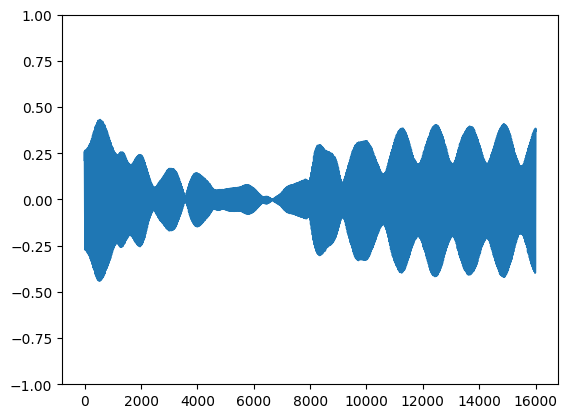

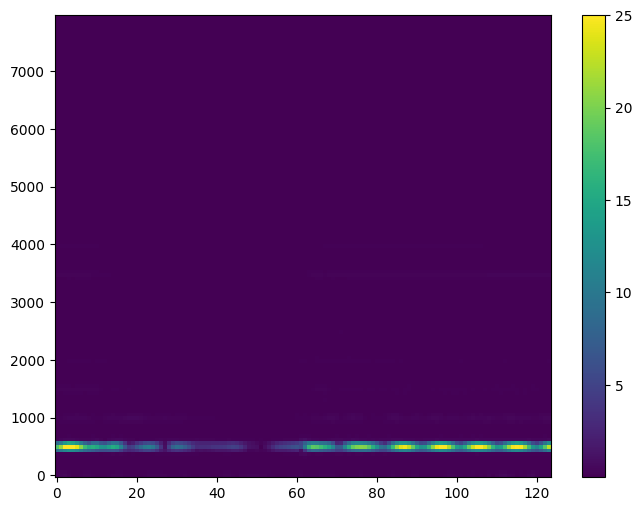

AttributeError: EagerTensor object has no attribute 'astype'. 
        If you are looking for numpy-related methods, please run the following:
        tf.experimental.numpy.experimental_enable_numpy_behavior()
      

In [ ]:
for wav, _, _ in split_fire_alarm_wav_ds.take(1):
  test_fire_alarm_wav = wav

plt.plot(test_fire_alarm_wav)
plt.ylim([-1, 1])
plt.show()

plot_spectrogram(get_arm_spectrogram(test_fire_alarm_wav), vmax=25)

display.display(display.Audio(test_fire_alarm_wav, rate=sample_rate))

#### White Noise

TensorFlow's [`tf.random.uniform(...)`](https://www.tensorflow.org/api_docs/python/tf/random/uniform) API can be used generate a Tensor of equal shape to the original audio. This Tensor can then be multiplied by a random scalar, and then added to the original audio samples. The [`tf.clip_by_value(...)`](https://www.tensorflow.org/api_docs/python/tf/clip_by_value) API will also be used to ensure the audio remains in the range of -1.0 to 1.0.

In [ ]:
def add_white_noise(audio):
  #generate noise and the scalar multiplier
  noise = tf.random.uniform(shape=tf.shape(audio), minval=-1, maxval=1)
  noise_scalar = tf.random.uniform(shape=[1], minval=0, maxval=0.2)

  # add them to the original audio
  audio_with_noise = audio + (noise * noise_scalar)

  # final clip the values to ensure they are still between -1 and 1
  audio_with_noise = tf.clip_by_value(audio_with_noise, clip_value_min=-1, clip_value_max=1)

  return audio_with_noise

Let's apply the white noise to the fire alarm sound and then plot it to compare. We can also listen to the difference.

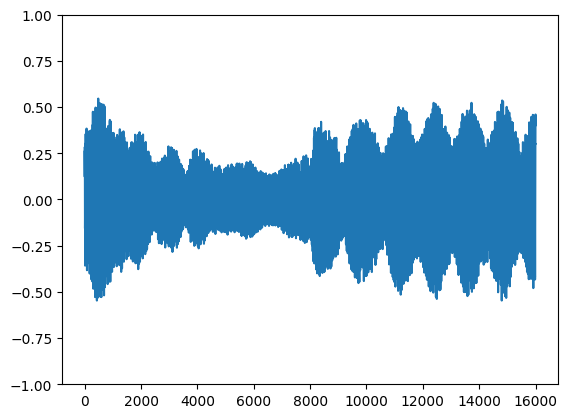

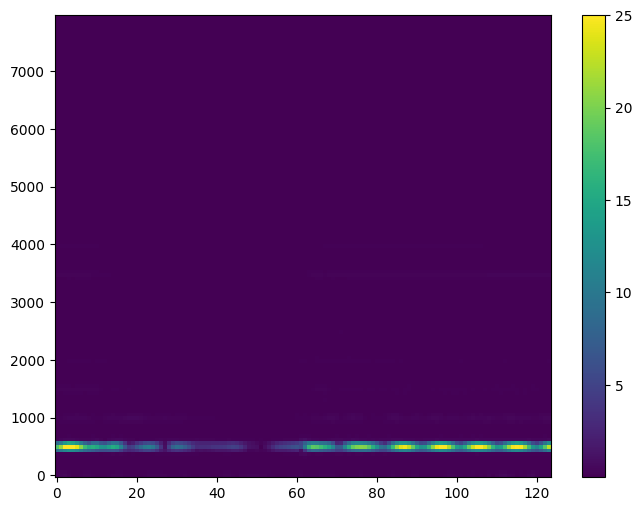

AttributeError: EagerTensor object has no attribute 'astype'. 
        If you are looking for numpy-related methods, please run the following:
        tf.experimental.numpy.experimental_enable_numpy_behavior()
      

In [ ]:
test_fire_alarm_with_white_noise_wav = add_white_noise(test_fire_alarm_wav)

plt.plot(test_fire_alarm_with_white_noise_wav)
plt.ylim([-1, 1])
plt.show()

plot_spectrogram(get_arm_spectrogram(test_fire_alarm_with_white_noise_wav), vmax=25)

display.display(display.Audio(test_fire_alarm_with_white_noise_wav, rate=sample_rate))

#### Random Silence

TensorFlow's [`tf.random.categorical(...)`](https://www.tensorflow.org/api_docs/python/tf/random/categorical) API can be used generate a Tensor of equal shape to the original audio containing mask of `True` or `False`. This mask can then be casted to a float type of 1.0 or 0.0, so that it can be multiplied by the original audio single to create random periods of silence.

In [ ]:
def add_random_silence(audio):
  audio_mask = tf.random.categorical(tf.math.log([[0.2, 0.8]]), num_samples=tf.shape(audio)[0])
  audio_mask = tf.cast(audio_mask, dtype=tf.float32)
  audio_mask = tf.squeeze(audio_mask, axis=0)

  # multiply the audio input by the mask
  augmented_audio = audio * audio_mask

  return augmented_audio

Let's apply the random silence to the fire alarm sound and then plot it to compare. We can also listen to the difference.

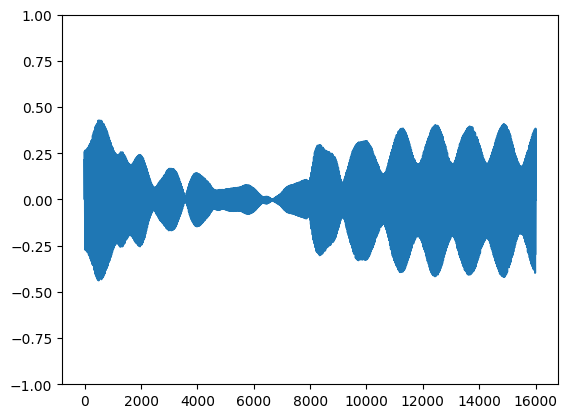

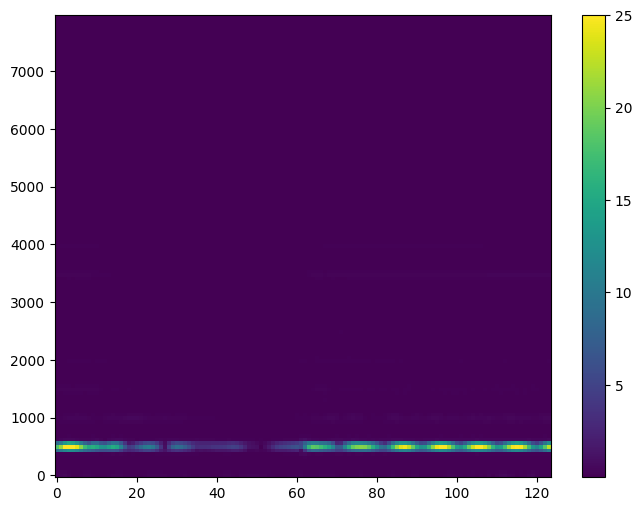

AttributeError: EagerTensor object has no attribute 'astype'. 
        If you are looking for numpy-related methods, please run the following:
        tf.experimental.numpy.experimental_enable_numpy_behavior()
      

In [ ]:
test_fire_alarm_with_random_silence_wav = add_random_silence(test_fire_alarm_wav)

plt.plot(test_fire_alarm_with_random_silence_wav)
plt.ylim([-1, 1])
plt.show()

plot_spectrogram(get_arm_spectrogram(test_fire_alarm_with_random_silence_wav), vmax=25)

display.display(display.Audio(test_fire_alarm_with_random_silence_wav, rate=sample_rate))

#### Audio Mixups

We can combine a fire alarm soundbite with a background noise soundbite to create a mixed up version of the two.

Let's select the first background noise soundbite do see how this can be done.

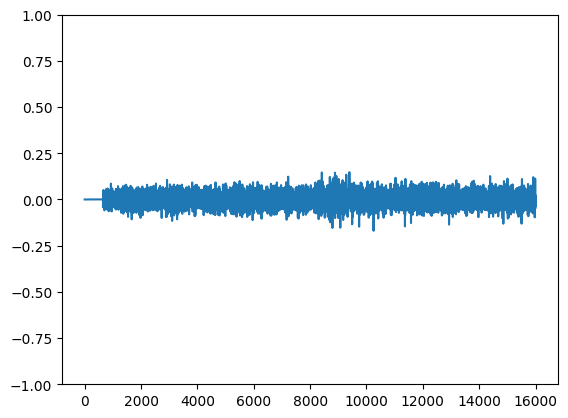

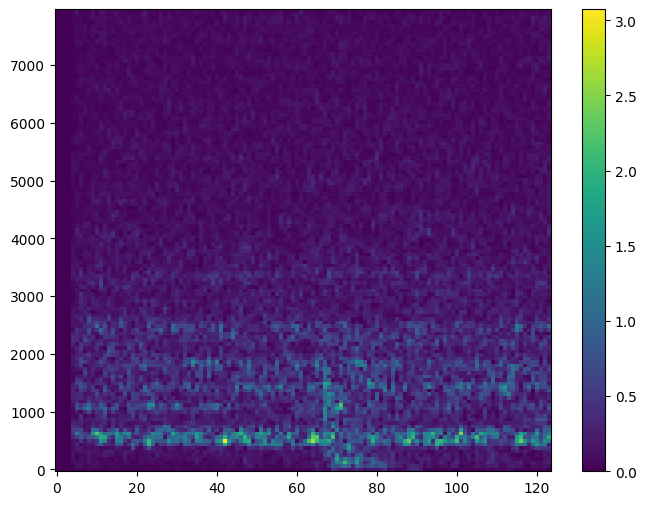

AttributeError: EagerTensor object has no attribute 'astype'. 
        If you are looking for numpy-related methods, please run the following:
        tf.experimental.numpy.experimental_enable_numpy_behavior()
      

In [ ]:
for wav, _, _ in split_background_noise_wav_ds.take(1):
  test_background_noise_wav = wav

plt.plot(test_background_noise_wav)
plt.ylim([-1, 1])
plt.show()

plot_spectrogram(get_arm_spectrogram(test_background_noise_wav))

display.display(display.Audio(test_background_noise_wav, rate=sample_rate))

We will multiply the background noise soundbite with a random scalar before adding it to the original fire alarm soundbite. Then ensure the mixed up value is between the range of -1.0 and 1.0.

In [ ]:
def add_audio_mixup(audio, mixup_audio):
  # randomly generate a scalar
  noise_scalar = tf.random.uniform(shape=[1], minval=0, maxval=1)

  # add the background noise to the audio
  augmented_audio = audio + (mixup_audio * noise_scalar)

  #final clip the values so they are stil between -1 and 1
  augmented_audio = tf.clip_by_value(augmented_audio, clip_value_min=-1, clip_value_max=1)

  return augmented_audio

Let's apply the audio mixup to the fire alarm sound and then plot it to compare. We can also listen to the difference.

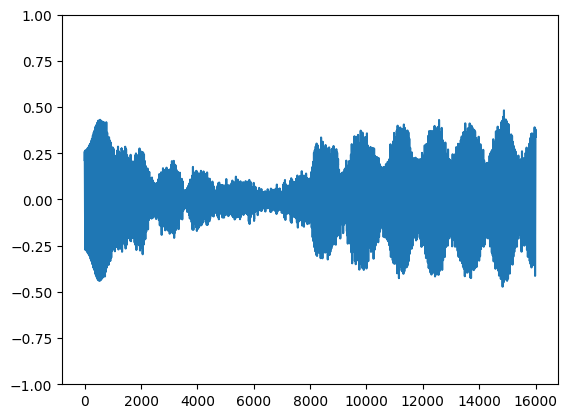

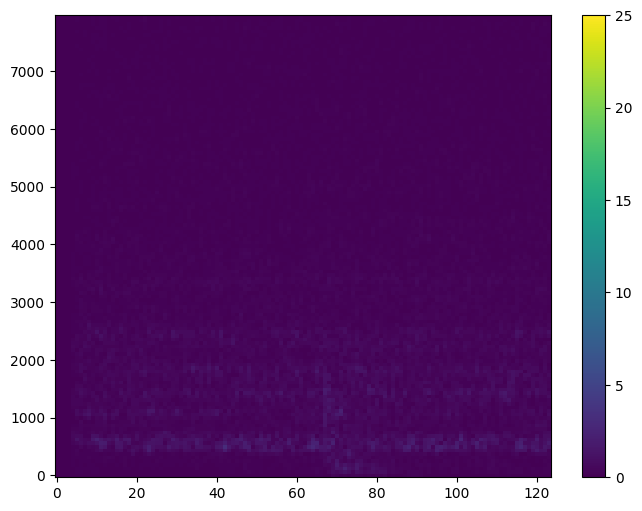

AttributeError: EagerTensor object has no attribute 'astype'. 
        If you are looking for numpy-related methods, please run the following:
        tf.experimental.numpy.experimental_enable_numpy_behavior()
      

In [ ]:
test_fire_alarm_with_mixup_wav = add_audio_mixup(test_fire_alarm_wav, test_background_noise_wav)

plt.plot(test_fire_alarm_with_mixup_wav)
plt.ylim([-1, 1])
plt.show()

plot_spectrogram(get_arm_spectrogram(test_fire_alarm_with_mixup_wav), vmax=25)

display.display(display.Audio(test_fire_alarm_with_mixup_wav, rate=sample_rate))

### Create Augmented Dataset

We can now combine all three augmententation techniques to balance our dataset.

First let's calculate how many augmented files we need to generate:

In [ ]:
num_augmented_fire_alarm_spectrograms = num_background_noise_spectrograms - num_fire_alarm_spectrograms

print(f'num_augmented_fire_alarm_spectrograms = {num_augmented_fire_alarm_spectrograms}')

num_augmented_fire_alarm_spectrograms = -48


Then we can divide by 3, to calculate how many augmented soundbites per technique to generate:

In [ ]:
num_white_noise_fire_alarm_spectrograms = num_augmented_fire_alarm_spectrograms // 3
num_random_silence_fire_alarm_spectrograms = num_augmented_fire_alarm_spectrograms // 3
num_audio_mixup_fire_alarm_spectrograms = num_augmented_fire_alarm_spectrograms // 3

print(f'num_white_noise_fire_alarm_spectrograms = {num_white_noise_fire_alarm_spectrograms}')
print(f'num_random_silence_fire_alarm_spectrograms = {num_random_silence_fire_alarm_spectrograms}')
print(f'num_audio_mixup_fire_alarm_spectrograms = {num_audio_mixup_fire_alarm_spectrograms}')

Select and shuffle the number of soundbites required:

In [ ]:
split_fire_alarm_wav_ds = split_fire_alarm_wav_ds.cache()
preaugmented_split_fire_alarm_wav = split_fire_alarm_wav_ds.shuffle(num_augmented_fire_alarm_spectrograms, seed=random_seed).take(num_augmented_fire_alarm_spectrograms)

Create the white noise augmented soundbites:

In [ ]:
def add_white_noise_for_map(wav, label, fold):
  return add_white_noise(wav), label, fold

white_noise_fire_alarm_wav_ds = preaugmented_split_fire_alarm_wav.take(num_white_noise_fire_alarm_spectrograms)
white_noise_fire_alarm_wav_ds = white_noise_fire_alarm_wav_ds.map(add_white_noise_for_map)

Create the random noise augmented soundbites:

In [ ]:
def add_random_silence_for_map(wav, label, fold):
  return add_random_silence(wav), label, fold

random_silence_fire_alarm_wav_ds = preaugmented_split_fire_alarm_wav.skip(num_white_noise_fire_alarm_spectrograms)
random_silence_fire_alarm_wav_ds = random_silence_fire_alarm_wav_ds.take(num_random_silence_fire_alarm_spectrograms)
random_silence_fire_alarm_wav_ds = random_silence_fire_alarm_wav_ds.map(add_random_silence_for_map)

Create the audio mixup augmented soundbites:

In [ ]:
audio_mixup_background_noise_ds = split_background_noise_wav_ds.shuffle(num_audio_mixup_fire_alarm_spectrograms).take(num_audio_mixup_fire_alarm_spectrograms)
audio_mixup_background_noise_iter = iter(audio_mixup_background_noise_ds.map(lambda x, y, z: x))

def add_audio_mixup_for_map(wav, label, fold):
  return add_audio_mixup(wav, next(audio_mixup_background_noise_iter)), label, fold

audio_mixup_split_fire_alarm_wav_ds = preaugmented_split_fire_alarm_wav.skip(num_white_noise_fire_alarm_spectrograms + num_random_silence_fire_alarm_spectrograms)
audio_mixup_split_fire_alarm_wav_ds = audio_mixup_split_fire_alarm_wav_ds.take(num_audio_mixup_fire_alarm_spectrograms)
audio_mixup_split_fire_alarm_wav_ds = audio_mixup_split_fire_alarm_wav_ds.map(add_audio_mixup_for_map)

Combine all the augmented soundbites together and map them to their spectrogram representations:

In [ ]:
augment_split_fire_alarm_wav_ds = tf.data.Dataset.concatenate(white_noise_fire_alarm_wav_ds, random_silence_fire_alarm_wav_ds)
augment_split_fire_alarm_wav_ds = tf.data.Dataset.concatenate(augment_split_fire_alarm_wav_ds, audio_mixup_split_fire_alarm_wav_ds)

augment_fire_alarm_spectrograms_ds = augment_split_fire_alarm_wav_ds.map(create_arm_spectrogram_for_map)

### Split Dataset

Now combine the spectrogram datasets, and split them into training, validation, and test sets. Instead of using the `fold` value to split them, we will shuffle all the items, and then split by percentage.

In [ ]:
full_ds = tf.data.Dataset.concatenate(fire_alarm_spectrograms_ds, background_noise_spectrograms_ds)
full_ds = full_ds.cache()

full_ds_size = calculate_ds_len(full_ds)

print(f'full_ds_size = {full_ds_size}')

full_ds = full_ds.shuffle(full_ds_size)

full_ds_size = 240


In [ ]:
train_ds_size = int(0.60 * full_ds_size)
val_ds_size = int(0.20 * full_ds_size)
test_ds_size = int(0.20 * full_ds_size)

train_ds = full_ds.take(train_ds_size)

remaining_ds = full_ds.skip(train_ds_size)
val_ds = remaining_ds.take(val_ds_size)
test_ds = remaining_ds.skip(val_ds_size)

# remove the folds column as it's no longer needed
remove_fold_column = lambda spectrogram, label, fold: (tf.expand_dims(spectrogram, axis=-1), label)

train_ds = train_ds.map(remove_fold_column)
val_ds = val_ds.map(remove_fold_column)
test_ds = test_ds.map(remove_fold_column)

train_ds = train_ds.cache().shuffle(1000).batch(32).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.cache().batch(32).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.cache().batch(32).prefetch(tf.data.AUTOTUNE)

### Replace Baseline Model Classification Head and Train Model

The model we previously trained on the ESC-50 dataset, predicted the presence of 50 sound types, and which resulted in the final dense layer of the model having 50 outputs. The new model we would like to create is a binary classifier, and needs to have a single output value.

We will load the baseline model, and swap out the final dense layer to match our needs:


In [ ]:
dummy_input = tf.random.normal((124, 129, 1)) # A batch of 1 sample with 10 features
y = baseline_model(dummy_input)

In [ ]:
# The baseline_model.layers[0] is now the Input layer, baseline_model.layers[1] is norm_layer
# The problematic Resizing layer has been removed.
# The output of baseline_model.layers[-2] (GlobalAveragePooling2D) is suitable for the head.
model_body = tf.keras.Model(inputs=baseline_model.input, outputs=baseline_model.layers[-2].output)

classifier_head = tf.keras.layers.Dense(1, activation="sigmoid")(model_body.output)

fine_tune_model = tf.keras.Model(model_body.input, classifier_head)


To freeze a layer in TensorFlow we can set `layer.trainable = False`. Let's loop through all the layers and do this:

In [ ]:
for layer in fine_tune_model.layers:
  layer.trainable = False

and now unfreeze the last layer (the head):

In [ ]:
fine_tune_model.layers[-1].trainable = True

Then we can `compile` the model, this time with using a binary crossentropy loss function as this model contains a single output.

In [ ]:
METRICS = [
      "accuracy",
]

fine_tune_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
    metrics=METRICS,
)

def scheduler(epoch, lr):
  if epoch < 10:
    return lr
  else:
    return lr

callbacks = [
    tf.keras.callbacks.EarlyStopping(verbose=1, patience=5),
    tf.keras.callbacks.LearningRateScheduler(scheduler)
]

Kick off training:

In [ ]:
EPOCHS = 25

history_1 = fine_tune_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=callbacks,
)

Epoch 1/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 0.0000e+00 - loss: -501098.5938 - val_accuracy: 0.0000e+00 - val_loss: -673237.8125 - learning_rate: 0.0100
Epoch 2/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.0000e+00 - loss: -695998.2500 - val_accuracy: 0.0000e+00 - val_loss: -855705.3125 - learning_rate: 0.0100
Epoch 3/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.0000e+00 - loss: -904308.8125 - val_accuracy: 0.0000e+00 - val_loss: -1073716.2500 - learning_rate: 0.0100
Epoch 4/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.0000e+00 - loss: -1033408.3125 - val_accuracy: 0.0000e+00 - val_loss: -1327000.7500 - learning_rate: 0.0100
Epoch 5/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.0000e+00 - loss: -1293194.3750 - val_accuracy: 0.0000e+00 - val_loss: -1634755.3750 - learning_rate: 0.0100
Epoch 6/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.0000e+00 - loss: -1765071.1250 - val_accuracy: 0.0000e+00 - val_loss: -2006624.6250 - l

Now unfreeze all the layers, and train for a few more epochs:

In [ ]:
for layer in fine_tune_model.layers:
  layer.trainable = True

fine_tune_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
    metrics=METRICS,
)

def scheduler(epoch, lr):
  return lr

callbacks = [
    tf.keras.callbacks.EarlyStopping(verbose=1, patience=5),
    tf.keras.callbacks.LearningRateScheduler(scheduler)
]

In [ ]:
EPOCHS = 10

history_2 = fine_tune_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=callbacks,
)

Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.0000e+00 - loss: -26608266.0000 - val_accuracy: 0.0000e+00 - val_loss: -27552826.0000 - learning_rate: 1.0000e-04
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.0000e+00 - loss: -27115788.0000 - val_accuracy: 0.0000e+00 - val_loss: -27566296.0000 - learning_rate: 1.0000e-04
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.0000e+00 - loss: -26722802.0000 - val_accuracy: 0.0000e+00 - val_loss: -27580022.0000 - learning_rate: 1.0000e-04
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.0000e+00 - loss: -25023476.0000 - val_accuracy: 0.0000e+00 - val_loss: -27593992.0000 - learning_rate: 1.0000e-04
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.0000e+00 - loss: -25314724.0000 - val_accuracy: 0.0000e+00 - val_loss: -27608262.0000 - learning_rate: 1.0000e-04
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.0000e+00 - loss: -28437390.0000 - val_accuracy: 0.00

In [ ]:
fine_tune_model.save("fine_tuned_model.keras")

Run the code cell below and then click the "Flash" button to upload the USB microphone example application to the board over USB.

Record the your own fire alarm sounds:

## Model Optimization

To optimize the model to run on the Arm Cortex-M0+ processor, we will use a process called model quantization. Model quantization converts the model’s weights and biases from 32-bit floating-point values to 8-bit values. The [pico-tflmicro](https://github.com/raspberrypi/pico-tflmicro) library, which is a port of TFLu for the RP2040’s Pico SDK contains Arm’s CMSIS-NN library, which supports optimized kernel operations for quantized 8-bit weights on Arm Cortex-M processors.



### Quantization Aware Training

We can use [TensorFlow’s Quantization Aware Training (QAT)](https://www.tensorflow.org/model_optimization/guide/quantization/training) feature to easily convert the floating-point model to quantized.

In [ ]:
import tensorflow as tf
final_model = tf.keras.models.load_model("fine_tuned_model.keras")

In [ ]:


# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(final_model)
converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS,      # normal TFLite ops
    tf.lite.OpsSet.SELECT_TF_OPS        # allow select TF ops (Flex)
]
converter._experimental_allow_all_select_tf_ops = True
tflite_model = converter.convert()

# Save the model.
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

Saved artifact at '/tmp/tmpv_02ivkv'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 124, 129, 1), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  134976598821584: TensorSpec(shape=(1, 1, 1, 1), dtype=tf.float32, name=None)
  134976598826960: TensorSpec(shape=(1, 1, 1, 1), dtype=tf.float32, name=None)
  134976598822544: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134976598820816: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134976598821008: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134976598823888: TensorSpec(shape=(), dtype=tf.resource, name=None)


In [ ]:
quant_aware_model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
    metrics=METRICS,
)

EPOCHS=1
quant_aware_history = quant_aware_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS
)

### Saving model in TFLite format

We will now use the [tf.lite.TFLiteConverter.from_keras_model(...)](https://www.tensorflow.org/api_docs/python/tf/lite/TFLiteConverter#from_keras_model) API to convert the quantized Keras model to TF Lite format, and then save it to disk as a `.tflite` file.

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(quant_aware_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

def representative_data_gen():
  for input_value, output_value in train_ds.unbatch().batch(1).take(100):
    # Model has only one input so each data point has one element.
    yield [input_value]

converter.representative_dataset = representative_data_gen
# Ensure that if any ops can't be quantized, the converter throws an error
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# Set the input and output tensors to uint8 (APIs added in r2.3)
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8
tflite_model_quant = converter.convert()

with open("tflite_model.tflite", "wb") as f:
  f.write(tflite_model_quant)